In [1]:
!python3 -c "import lightning" || pip install lightning==2.2.4
!python3 -c "import torchsummary" || pip install torchsummary

In [2]:
# Resnet embedings
from torchvision import models
from torch import nn
from torch.utils.data import Dataset
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
import lightning as L
import torch
import os
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from skimage import data, io
from sklearn.model_selection import train_test_split
import random
from torchvision.transforms import v2
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.loggers import CSVLogger

In [3]:
print(torch.cuda.get_arch_list())


['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_37', 'sm_90']


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
OBJECTS_ROOT = r"/home/jovyan/pollen_dataset_2024_05_08_objects"

In [7]:
random.seed(42)

In [8]:
def pad2size(image, size=(224, 224)):
    return ImageOps.fit(image, size)

class PollenTripletDataset(Dataset):
    def __init__(self, img_dir, classes, 
                 static_transform=None, 
                 random_transform=None,
                inflation_rate=1):
        self.known_classes = classes
        self.known_classes.sort()
        self.transform = random_transform
        self._images = {}
        self.inflation_rate=inflation_rate

        total_samples = 0
        for c in tqdm(self.known_classes):
            self._images[c] = glob(os.path.join(img_dir, c, "*.png"))
            print(f"{len(self._images[c])} samples in the class {c}")
            total_samples += len(self._images[c])
            self._images[c] = [ Image.open(img_path) for img_path in tqdm(self._images[c])] 
            if static_transform is not None:
                self._images[c] = [ static_transform(img) for img in tqdm(self._images[c])] 
        print(f"Total samples: {total_samples}")
        self._images = list(self._images.values())
            
    def __len__(self):
        return len(self._images) * self.inflation_rate

    def __getitem__(self, idx):
        idx = idx % len(self._images)
        anchor = random.choice(self._images[idx])
        positive = random.choice(self._images[idx])
        neg_weights = [1]*len(self._images)
        neg_weights[idx] = 0
        negative = random.choices(self._images, weights=neg_weights)[0]
        negative = random.choice(negative)
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

known_classes = os.listdir(OBJECTS_ROOT)

print(f"All known classes: {known_classes}")
train_classes, val_classes = train_test_split(known_classes, test_size=0.33, random_state=42)
print(f"Train subset classes: {train_classes}")
print(f"Validation subset classes: {val_classes}")


input_size=(224, 224)

static_transforms = v2.Compose([
    v2.Lambda(pad2size),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


print("\nLoad Train Dataset")
dataset_train = PollenTripletDataset(OBJECTS_ROOT, train_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Validation Dataset")
dataset_val = PollenTripletDataset(OBJECTS_ROOT, val_classes, static_transform=static_transforms, inflation_rate=100)


All known classes: ['Quercus', 'Tilia', 'Corylus', 'Acer', 'Populus tremula', 'Betula', 'Alnus', 'Pinus', 'Salix']
Train subset classes: ['Quercus', 'Salix', 'Corylus', 'Populus tremula', 'Acer', 'Alnus']
Validation subset classes: ['Pinus', 'Tilia', 'Betula']

Load Train Dataset


  0%|          | 0/6 [00:00<?, ?it/s]

319 samples in the class Acer


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

25 samples in the class Alnus


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

141 samples in the class Corylus


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

201 samples in the class Populus tremula


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

90 samples in the class Quercus


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

227 samples in the class Salix


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

Total samples: 1003

Load Validation Dataset


  0%|          | 0/3 [00:00<?, ?it/s]

206 samples in the class Betula


  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

67 samples in the class Pinus


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

114 samples in the class Tilia


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

Total samples: 387


In [9]:
def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [10]:
training_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size= 48,
    shuffle= True,
    num_workers= 6
)
val_loaderr = torch.utils.data.DataLoader(
    dataset_val, 
    batch_size= 4,
    shuffle= True,
    num_workers= 6
)

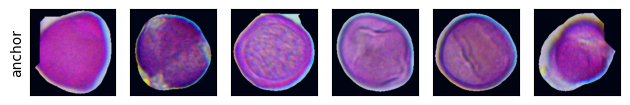

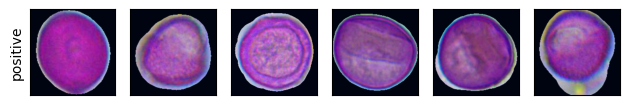

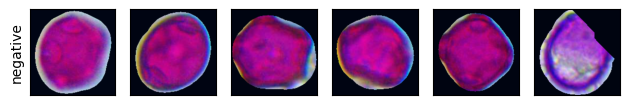

In [11]:
for anchor, positive, negative in training_loader:
    plot(anchor[:6], row_title=["anchor"])
    plot(positive[:6], row_title=["positive"])
    plot(negative[:6], row_title=["negative"])
    break

In [12]:
class EmbeddingModel(nn.Module):
    def __init__(self, embedings=128):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.embedings = nn.Linear(2048, embedings)
        self.model.fc = nn.Identity()

    def forward(self, x):
        x = self.model(x)
        x = self.embedings(x)
        x = nn.functional.normalize(x) # L2 normalization to put all values on a sphere
        return x

class PollenEmbedingsModule(L.LightningModule):
    def __init__(self,
                 optim_lr=0.001,
                 optim_betas=(0.9, 0.999),
                 optim_eps=1e-08,
                 optim_weight_decay=0,
                 check_val=20
                 ):
        super().__init__()
        # call this to save (arguments) to the checkpoint
        self.save_hyperparameters()

        self.loss_function = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

        self.best_score = 0
        self.best_val_epoch = -1

        self.model = EmbeddingModel()

        self.validation_step_outputs = []

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        anchor, positive, negative = batch

        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)
        
        loss = self.loss_function(anchor_out, positive_out, negative_out)
        self.log("train_loss", loss)
        return loss

    def on_train_epoch_end(self):
        pass

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        anchor, positive, negative = batch

        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)
        
        loss = self.loss_function(anchor_out, positive_out, negative_out)

        pred = {"val_loss": loss, "val_number": len(anchor_out)}
        self.validation_step_outputs.append(pred)

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]

        mean_val_loss = torch.tensor(val_loss / num_items)

        tensorboard_logs = {
            "val_loss": mean_val_loss
        }
        self.log("val_loss", mean_val_loss)
        self.validation_step_outputs.clear()  # free memory

        if mean_val_loss > self.best_score:
            self.best_score = mean_val_loss
            self.best_val_epoch = self.current_epoch

        return {"log": tensorboard_logs}

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=self.hparams.optim_lr,
                                          betas=self.hparams.optim_betas,
                                          eps=self.hparams.optim_eps,
                                          weight_decay=self.hparams.optim_weight_decay)
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(self.optimizer, factor=0.1, patience=10),
                "frequency": self.hparams.check_val,
                "monitor": "val_loss",
                "interval": "epoch",
            }
        }

In [13]:
model = PollenEmbedingsModule(check_val=2)

In [14]:
model = model.to(device)
summary(model.model, input_size=(3, 224, 224))

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [15]:
checkpoint_callback = ModelCheckpoint(
    filename='checkpoint-{epoch:02d}-{val_loss:.2f}',
    # auto_insert_metric_name=False,
    dirpath="./history",
    monitor='val_loss',
    mode='min')
lr_logger = LearningRateMonitor()
logger = CSVLogger("logs", name="triplet_1")

In [16]:
trainer = L.Trainer(logger=logger,
                    log_every_n_steps=1,  # Increase, if epoch size is large
                    callbacks=[checkpoint_callback, lr_logger],
                    precision="16-mixed",
                    check_val_every_n_epoch=model.hparams.check_val,
                    max_epochs=100,
                    accumulate_grad_batches=2,
                    )

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, 
            train_dataloaders=training_loader, 
            val_dataloaders=val_loaderr,     
)

Missing logger folder: logs/triplet_1
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | loss_function | TripletMarginLoss | 0     
1 | model         | EmbeddingModel    | 23.8 M
----------------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.081    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]